### Load and inspect the data

In [27]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

EDGE_COLS = [
    'Bwd Packet Length Min', 'Protocol_6', 'Bwd Packets/s', 'FWD Init Win Bytes',
    'Packet Length Std', 'FIN Flag Count', 'SrcPortRange_registered',
    'Packet Length Min', 'Fwd Seg Size Min', 'DstPortRange_well_known',
    'Bwd IAT Total', 'SYN Flag Count', 'Bwd Packet Length Std'
]
LABEL_COL = "target"
ID_COLS = ['Src IP', 'Dst IP', 'Timestamp']

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

X_train = df_train.drop(columns=[LABEL_COL, "Src IP", "Dst IP", "Timestamp"])
y_train = df_train[LABEL_COL]
X_test  = df_test.drop(columns=[LABEL_COL, "Src IP", "Dst IP", "Timestamp"])
y_test  = df_test[LABEL_COL]

print(df_train.shape)
print(df_train.columns)
print(df_train.loc[1])

(25901651, 17)
Index(['Timestamp', 'Src IP', 'Dst IP', 'Bwd Packet Length Min', 'Protocol_6',
       'Bwd Packets/s', 'FWD Init Win Bytes', 'Packet Length Std',
       'FIN Flag Count', 'SrcPortRange_registered', 'Packet Length Min',
       'Fwd Seg Size Min', 'DstPortRange_well_known', 'Bwd IAT Total',
       'SYN Flag Count', 'Bwd Packet Length Std', 'target'],
      dtype='object')
Timestamp                  2018-02-16 12:38:45.787171
Src IP                                   172.31.66.26
Dst IP                                  23.219.88.169
Bwd Packet Length Min                               0
Protocol_6                                       True
Bwd Packets/s                                0.133515
FWD Init Win Bytes                               8192
Packet Length Std                          113.214348
FIN Flag Count                                      0
SrcPortRange_registered                         False
Packet Length Min                                   0
Fwd Seg Size Min  

### Examine the data

In [28]:
print("Training distribution:")
print(y_train.value_counts())
print(f"Training malicious ratio: {y_train.value_counts()[1] / len(y_train):.6f}")

print("\nTest distribution:")
print(y_test.value_counts())
print(f"Test malicious ratio: {y_test.value_counts()[1] / len(y_test):.6f}")

Training distribution:
target
0    23414921
1     2486730
Name: count, dtype: int64
Training malicious ratio: 0.096007

Test distribution:
target
0    5391219
1    1084194
Name: count, dtype: int64
Test malicious ratio: 0.167432


### Train the XGBoost model with best hyper-params

In [29]:
scale = y_train.value_counts()[0] / y_train.value_counts()[1]
model = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1_000,
    max_depth=5,
    min_child_weight=1,
    gamma=1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0,
    scale_pos_weight=scale,
    # max_delta_step=1,
    eval_metric="auc",
    tree_method="hist",
    random_state=42
)

model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [30]:
# Lower the classification threshold

from sklearn.metrics import precision_recall_curve

y_proba = model.predict_proba(X_test)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, y_proba)

# pick threshold that maximizes F1
import numpy as np
f1 = 2*prec*rec/(prec+rec+1e-8)
best_thr = thr[np.argmax(f1)]
print("Best threshold:", best_thr)

y_pred = (y_proba >= best_thr).astype(int)

Best threshold: 0.0028296125


In [31]:
from sklearn.metrics import average_precision_score
print("PR-AUC:", average_precision_score(y_test, y_proba))

PR-AUC: 0.9829129947783966


In [32]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print(cm)

[[5379285   11934]
 [    202 1083992]]


### Plot the ROC curve

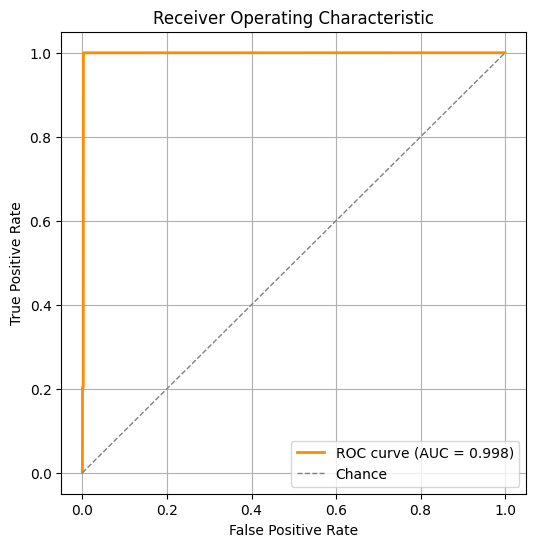

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Precision–Recall curve

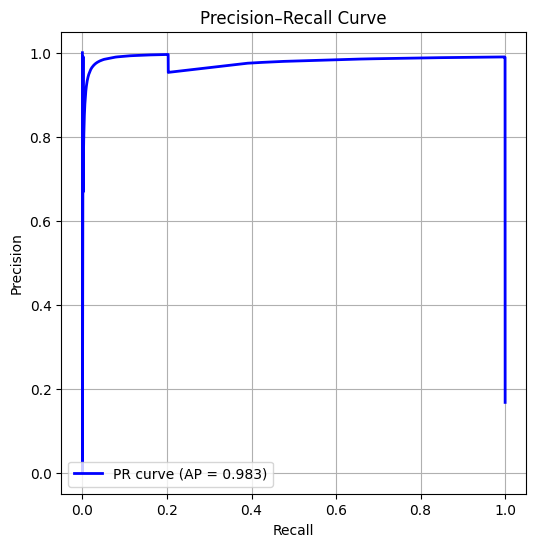

In [34]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, thr = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(rec, prec, color='blue', lw=2, label=f'PR curve (AP = {ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

Plot distribution of predicted probabilities for both classes

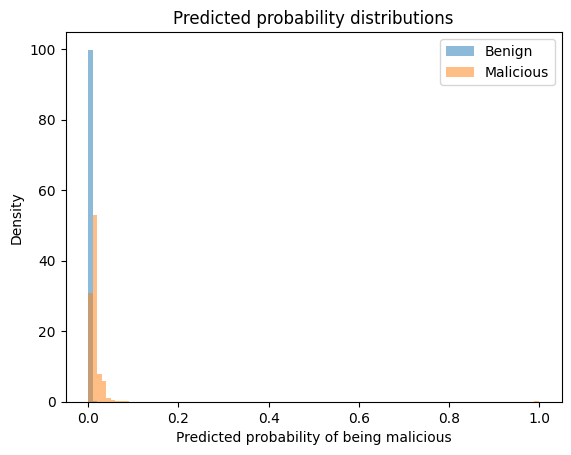

In [35]:
import matplotlib.pyplot as plt

y_proba = model.predict_proba(X_test)[:,1]
plt.hist(y_proba[y_test==0], bins=100, alpha=0.5, label="Benign", density=True)
plt.hist(y_proba[y_test==1], bins=100, alpha=0.5, label="Malicious", density=True)
plt.legend()
plt.xlabel("Predicted probability of being malicious")
plt.ylabel("Density")
plt.title("Predicted probability distributions")
plt.show()

In [36]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

y_proba = model.predict_proba(X_test)[:,1]
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("AUPRC:", average_precision_score(y_test, y_proba))

print("Malicious/Benign ratio:", y_train.value_counts()[0] / y_train.value_counts()[1])
print(y_train.value_counts())

ROC-AUC: 0.9983558144145372
AUPRC: 0.9829129947783966
Malicious/Benign ratio: 9.415948253328668
target
0    23414921
1     2486730
Name: count, dtype: int64


### Step 7. (Optional) Time-aware cross-validation

In [37]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

complete_df = pd.concat([df_train, df_test])
tscv = TimeSeriesSplit(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(tscv.split(complete_df)):
    Xtr, Xte = complete_df.iloc[train_idx][EDGE_COLS], complete_df.iloc[test_idx][EDGE_COLS]
    ytr, yte = complete_df.iloc[train_idx][LABEL_COL], complete_df.iloc[test_idx][LABEL_COL]
    model.fit(Xtr, ytr)
    preds = model.predict_proba(Xte)[:,1]
    auc = roc_auc_score(yte, preds)
    print(f"Fold {fold+1}: AUC={auc:.4f}")

Fold 1: AUC=0.5000
Fold 2: AUC=0.6774
Fold 3: AUC=0.2626
Fold 4: AUC=1.0000
Fold 5: AUC=0.9983
